In [10]:
################ Import packages ###################
#Basic
import numpy as np    # 1.24.4
import pandas as pd
import pickle

#Plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()    
%matplotlib inline

#Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch import nn

#SKlearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#SHAP
import shap     # 0.43.0
shap.initjs()

#others
from scipy.stats import skew, kurtosis, norm

In [11]:
##### import data #####
housing_modified = pd.read_csv("../data/housing_modified.csv")     # housing_modified is DataFrame
x_data = housing_modified[['CRIM','ZN','INDUS','CHAS','NOX','RM','GE','DIS','RAD','TAX','PRTATIO','LSTAT']]
y_data = housing_modified[['PRICE']]
x_column_names = x_data.columns
y_column_names = y_data.columns  

with open('bosten_data_split.pickle', 'rb') as f:
    indexs = pickle.load(f)
y_train_index, y_val_index, y_test_index = indexs

x_train= housing_modified.iloc[y_train_index][x_column_names]
x_val= housing_modified.iloc[y_val_index][x_column_names]
x_test= housing_modified.iloc[y_test_index][x_column_names]

y_train= housing_modified.iloc[y_train_index][y_column_names]
y_val= housing_modified.iloc[y_val_index][y_column_names]
y_test= housing_modified.iloc[y_test_index][y_column_names]

In [12]:
# calculate the standardation x_train
scaler_x = StandardScaler()
scaler_x.fit(x_train)

# give the standardization to all data
x_train_std = pd.DataFrame(scaler_x.transform(x_train), columns=x_column_names)
x_val_std = pd.DataFrame(scaler_x.transform(x_val), columns=x_column_names)
x_test_std = pd.DataFrame(scaler_x.transform(x_test), columns=x_column_names)

# same for y
scaler_y = StandardScaler()
scaler_y.fit(y_train)

y_train_std = pd.DataFrame(scaler_y.transform(y_train), columns=y_column_names)
y_val_std = pd.DataFrame(scaler_y.transform(y_val), columns=y_column_names)
y_test_std = pd.DataFrame(scaler_y.transform(y_test), columns=y_column_names)

In [13]:
# canculate mean and standard-deviation
x_train_mean = x_train.mean()
x_train_STD = x_train.std()
y_train_mean = y_train.mean()
y_train_STD = y_train.std()

# reverse standardization
x_train_inv = scaler_x.inverse_transform(x_train_std)
y_train_inv = scaler_y.inverse_transform(y_train_std)
x_test_inv = scaler_x.inverse_transform(x_test_std)
y_test_inv = scaler_y.inverse_transform(y_test_std)

In [14]:
#####v Network structure ##### 
class FullyConnectedNuralNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNuralNetwork,self).__init__()
        self.hidden1=nn.Sequential(
                nn.Linear(in_features=12,out_features= 100,bias=True),
                nn.ReLU())
        self.hidden2=nn.Sequential(
                #nn.Dropout(p=0.3), #add dropout
                nn.Linear(in_features=100,out_features=50,bias=True),
                nn.ReLU())
        
        self.predict=nn.Sequential(
                nn.Dropout(p=0.1),
                nn.Linear(in_features= 50,out_features=1,bias=True))
                #nn.ReLU())
                
    def forward(self,x):
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.predict(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testnet = FullyConnectedNuralNetwork().to(device)
optimizer = Adam(testnet.parameters(), lr = 0.0001)     # optimizer can be Adam or SGD
loss_func = nn.MSELoss()                                          
epoch= 500                                           

In [15]:
##### definedatasets and dataloader
train_data= TensorDataset(torch.from_numpy(x_train_std.to_numpy().astype(np.float32)), torch.from_numpy(y_train_std.to_numpy().astype(np.float32)))
validation_data= TensorDataset(torch.from_numpy(x_val_std.to_numpy().astype(np.float32)), torch.from_numpy(y_val_std.to_numpy().astype(np.float32)))
test_data= TensorDataset(torch.from_numpy(x_test_std.to_numpy().astype(np.float32)), torch.from_numpy(y_test_std.to_numpy().astype(np.float32)))

train_loader= DataLoader(dataset=train_data,batch_size=64,shuffle=True, num_workers=2)
validation_loader= DataLoader(dataset=validation_data,batch_size=64,shuffle=True, num_workers=2)
test_loader= DataLoader(dataset=test_data,batch_size=64,shuffle=False, num_workers=2)

In [16]:
def DP_va(c): #input should be a dataframe file

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    testnet = FullyConnectedNuralNetwork().to(device)
    testnet.load_state_dict(torch.load("./model_state_noReLU_Stdall_dp0.1.pth", weights_only=True))
    testnet.train()

    # scaler_y = StandardScaler()
    # scaler_y.fit(y_train)
    #counting droput results
    d_update= []
    c= torch.from_numpy(c).to(device) 
    
    for i in range(100):
        d= testnet(c)
        d= d.cpu()
        #print(type(b))
        d= d.detach().numpy()
        d= scaler_y.inverse_transform(d)   # reverse transform back to original value range
        d_update.append(d)
        i= i+1

    d_update_array= np.array(d_update)
    new_d= np.squeeze(np.array(d_update_array))
    d_add_row= new_d.shape[0]
    
    if len(new_d.shape) ==2: 
       d_add_colum= new_d.shape[1]

    else: #elif new
       #d_add_colum= d_update_array.shape[1]
       new_d= new_d[:, np.newaxis]
       d_add_colum= new_d.shape[1]

    #counting variances depends on columms
    d_final= []
    for j in range(d_add_colum):
        
        colum_var = np.var(new_d[:, j])
        d_final.append(colum_var)
    
    d= np.array(d_final)
    d= d[:, np.newaxis] #add one y axis demension 
    return d

correct output d of last function, and update comments of next block

In [18]:
##### show the prediction of test data 
total_test_output= DP_va(x_test_std.to_numpy().astype(np.float32))
#print('original_total_test_output:', type(total_test_output))

total_test_output_data_pd= pd.DataFrame(total_test_output) #change output from numpy to dataframework
total_test_output_data_pd.columns= ['PRICE']
#print('total_test_output_data_pd:', total_test_output_data_pd)

##### find out the peaks values from test
top_5_min = total_test_output_data_pd.nsmallest(5, 'PRICE')     # shape is (5, 1)
top_5_min_np= np.array(top_5_min).reshape(1, 5).flatten()
print('top_5_min_np:', top_5_min_np, top_5_min_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_min_np) #return to true or false(boolean mask)
y_test_top_5_min_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_min_index:', y_test_top_5_min_index)

top_5_max = total_test_output_data_pd.nlargest(5, 'PRICE')
top_5_max_np= np.array(top_5_max).reshape(1, 5).flatten()
print('top_5_max_np:', top_5_max_np, top_5_max_np.shape)

mask = total_test_output_data_pd['PRICE'].isin(top_5_max_np) #return to true or false(boolean mask)
y_test_top_5_max_index = total_test_output_data_pd.loc[mask].index
print('y_test_top_5_max_index:', y_test_top_5_max_index)

with open("./y_test_minmax_varainces_index.pickle", "wb") as f:
    pickle.dump([y_test_top_5_min_index, y_test_top_5_max_index], f)

top_5_min_np: [0.09994148 0.10765589 0.1154579  0.11895256 0.12446223] (5,)
y_test_top_5_min_index: Index([16, 23, 24, 48, 56], dtype='int64')
top_5_max_np: [5.969556  4.0480804 4.0101705 3.0727584 2.8020716] (5,)
y_test_top_5_max_index: Index([0, 45, 52, 65, 86], dtype='int64')


In [19]:
explainer= shap.KernelExplainer(DP_va, x_train_std.to_numpy().astype(np.float32)) #x is DataFrame here, use x_train_std as background data
shap_values = explainer.shap_values(x_test_std.to_numpy().astype(np.float32))     #shap_values is a list here

Using 353 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/102 [00:00<?, ?it/s]

In [21]:
expected_value = explainer.expected_value
print('expected_value:', expected_value)

expected_value: [0.72052195]


### Global XAI Variances ###

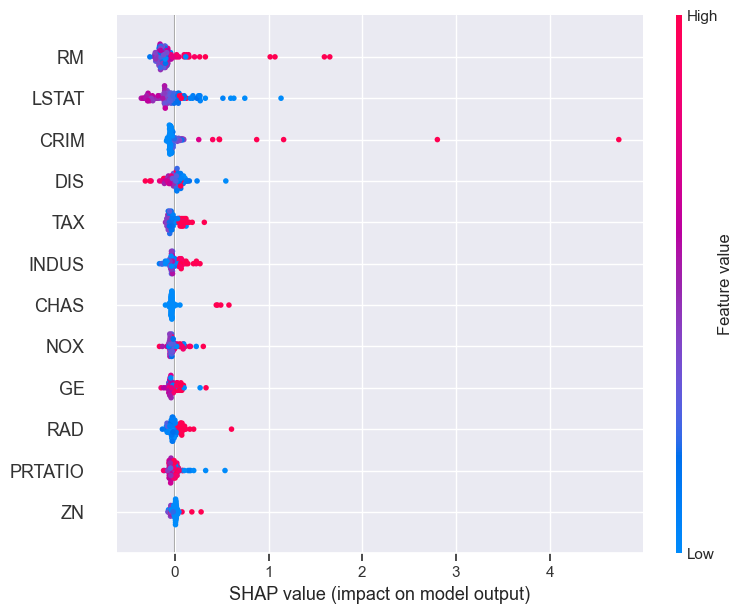

In [22]:
shap.summary_plot(shap_values[0], x_test_std, show= False)

image_name = f'../result/houseprice_SHAP_xai_variance_global_summary.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

#CRIM犯罪率 0-max                     #ZN住宅用地所占比例 0-100                 #INDUS城镇中非住宅用地所占比例 0-max
#CHAS是否穿过查尔斯河 0-1               #NOX氮氧化污染物   0-max                 #RM每栋住宅的房间数 min-max
#GE1940年以前建成的自住单位的比例 3-max   #DIS距离5个波士顿的就业中心的加权距离 min-max  #RAD距离高速公路的便利指数 1- max
#TAX每一万美元的不动产税率 min- max       #PRTATIO城镇中的教师学生比例  min-max    #LSTAT低收入群比例 min-max   

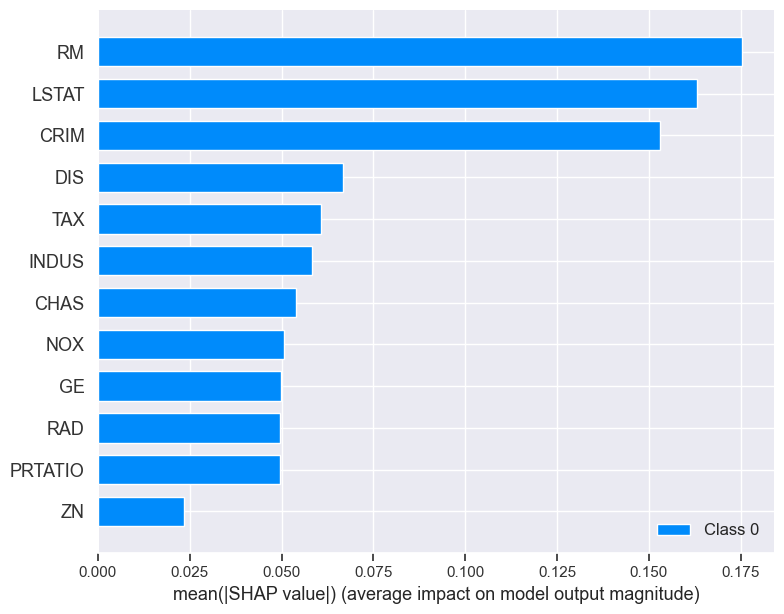

In [23]:
shap.summary_plot(shap_values, x_test_std, show= False)
image_name = f'../result/houseprice_SHAP_xai_variance_global.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

#### Local XAI Variances #####

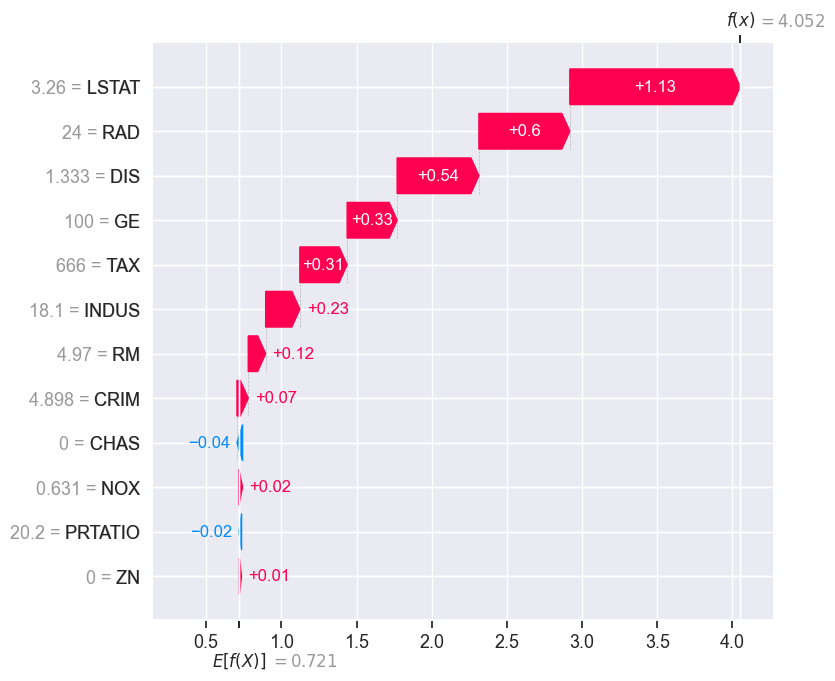

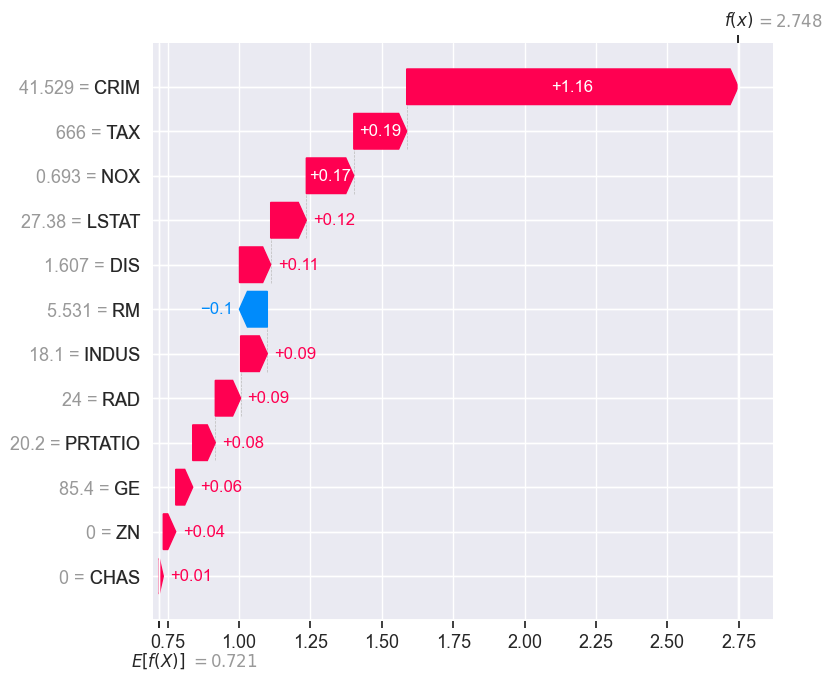

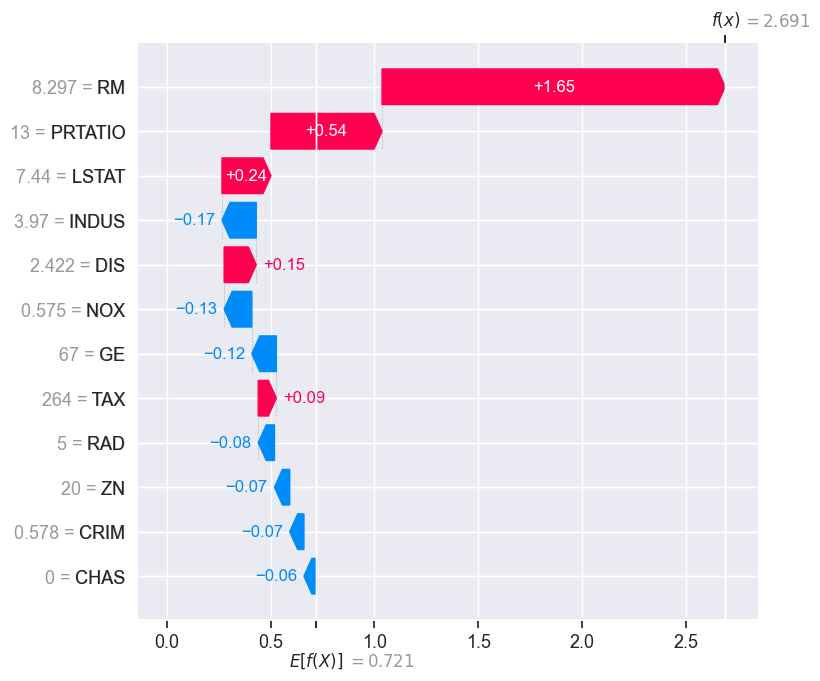

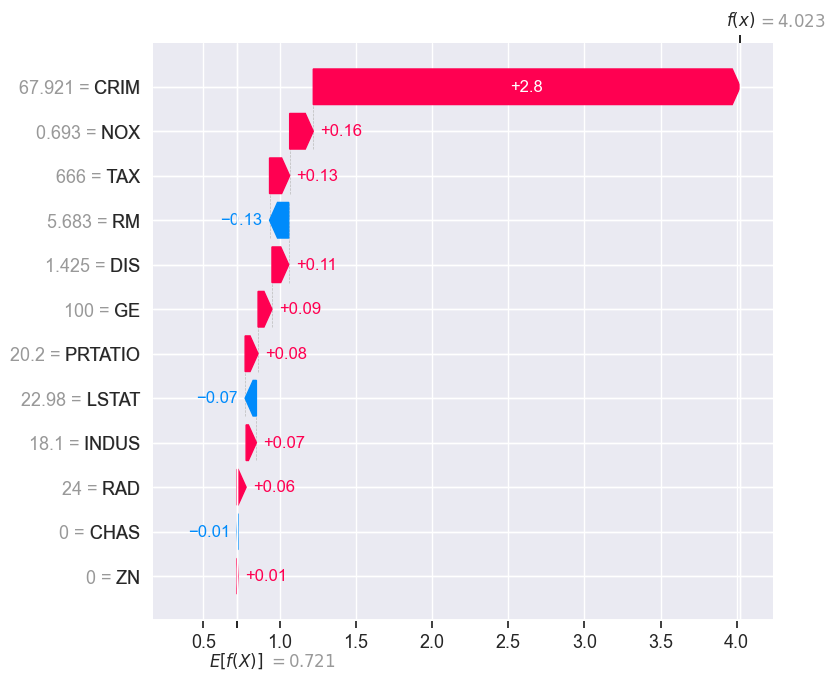

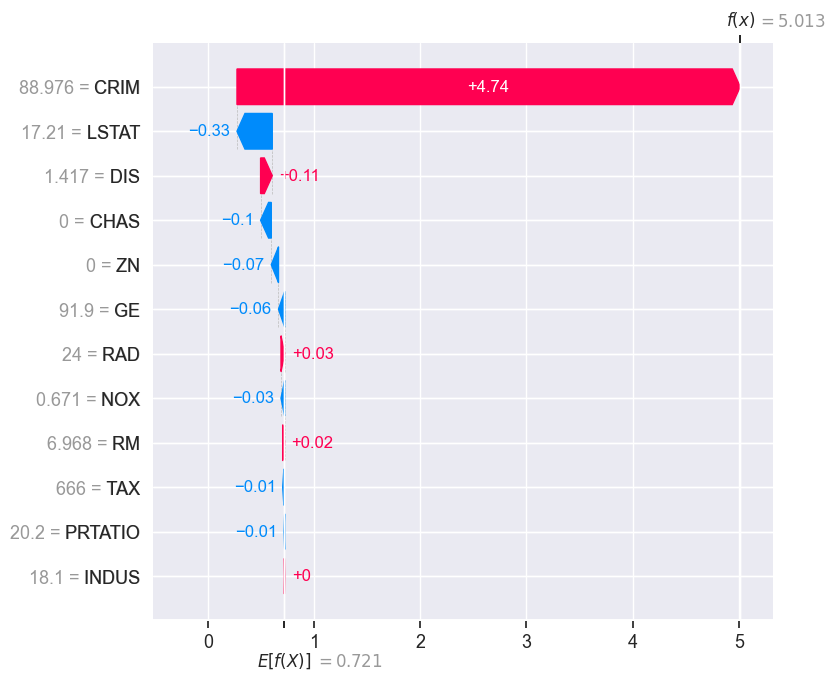

In [24]:
for i in range(5):
    
    selected_index= y_test_top_5_max_index[i]
    # Convert shap_values to shap.Explanation object
    shap_explanation = shap.Explanation(values=shap_values[0][selected_index], 
                                        base_values=expected_value, 
                                        data=pd.Series(x_test_inv[selected_index], index=x_column_names))

    # Plot the waterfall plot with all features
    shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)

    # Display the plot
    image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_max_index{selected_index}_waterfall.png'
    plt.savefig(image_name, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

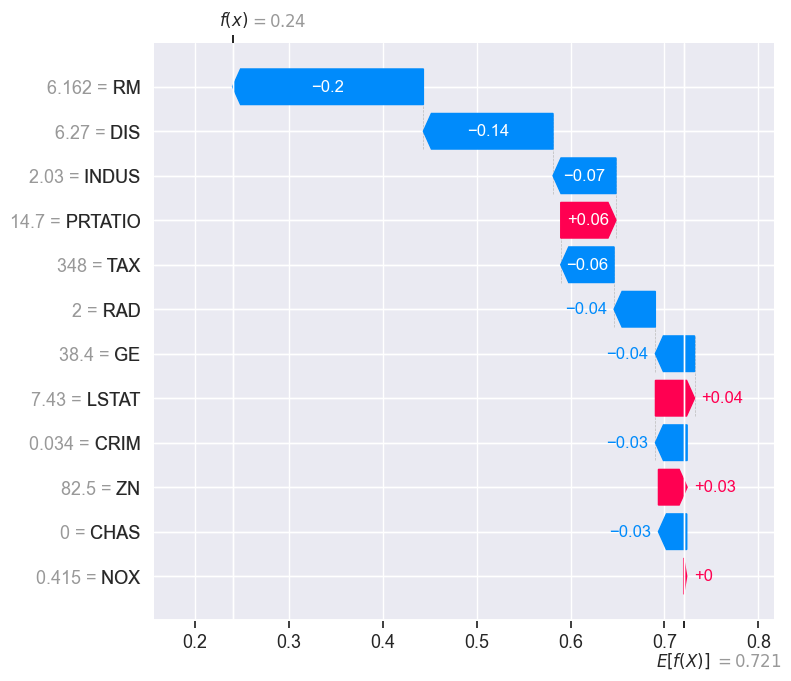

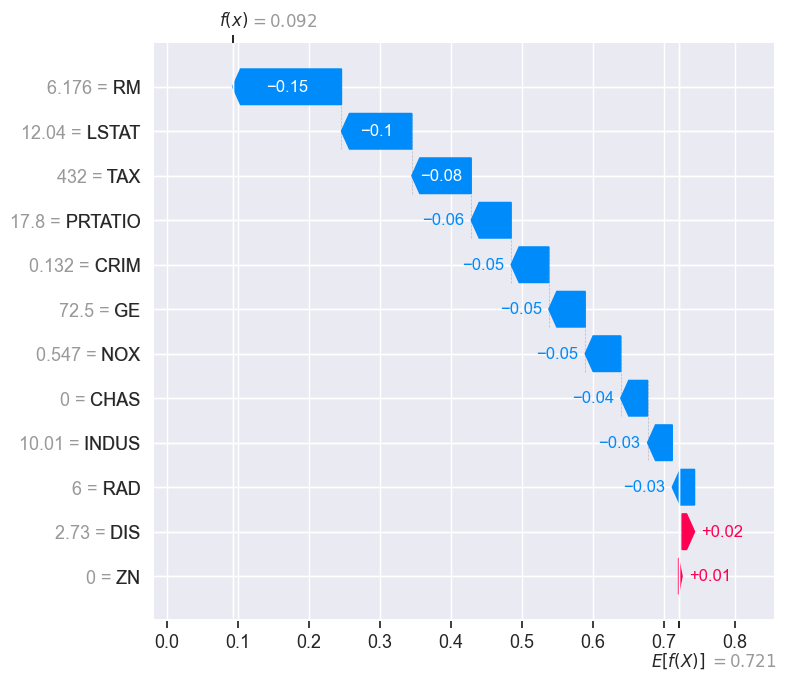

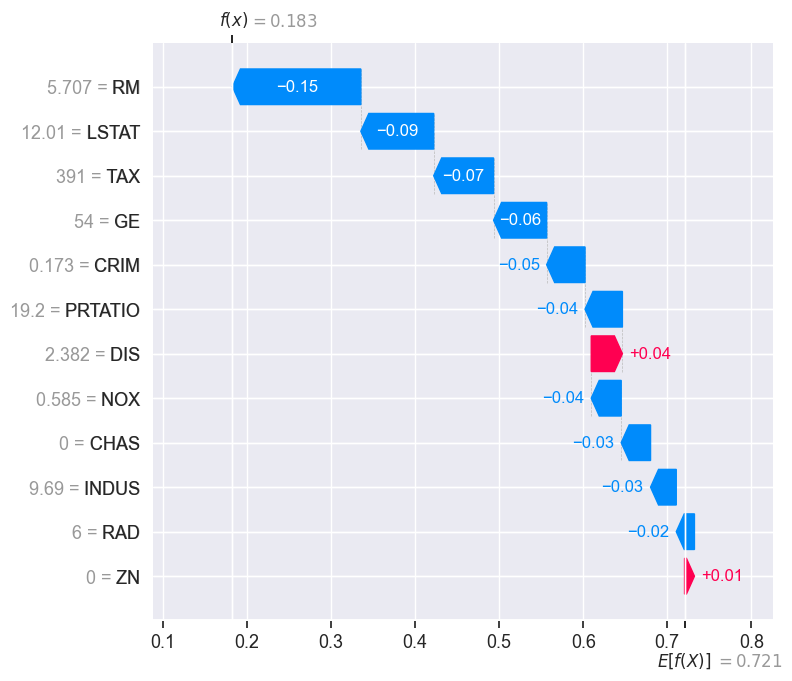

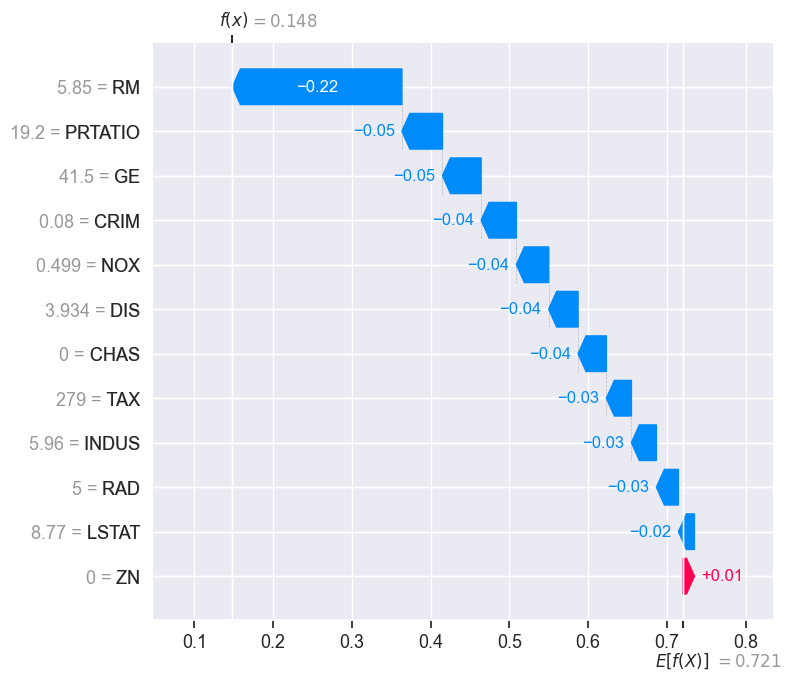

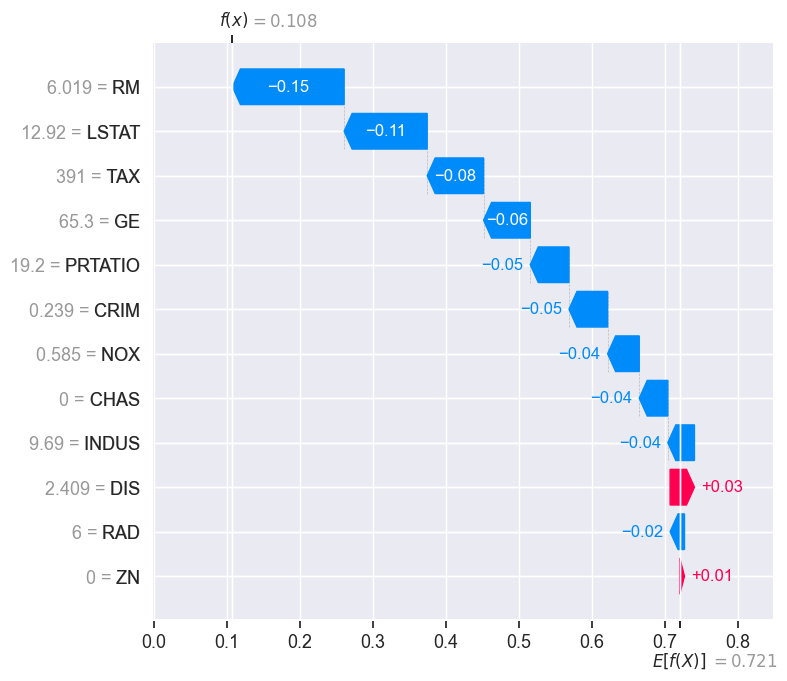

In [25]:
for i in range(5):
    
    selected_index= y_test_top_5_min_index[i]
    # Convert shap_values to shap.Explanation object
    shap_explanation = shap.Explanation(values=shap_values[0][selected_index], 
                                        base_values=expected_value, 
                                        data=pd.Series(x_test_inv[selected_index], index=x_column_names))

    # Plot the waterfall plot with all features
    shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)

    # Display the plot
    image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_min_index{selected_index}_waterfall.png'
    plt.savefig(image_name, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

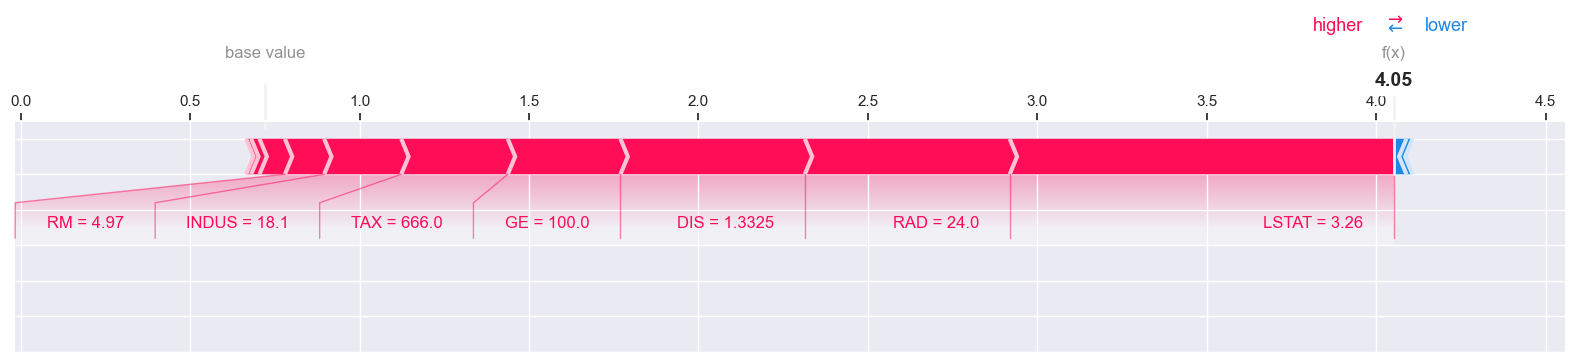

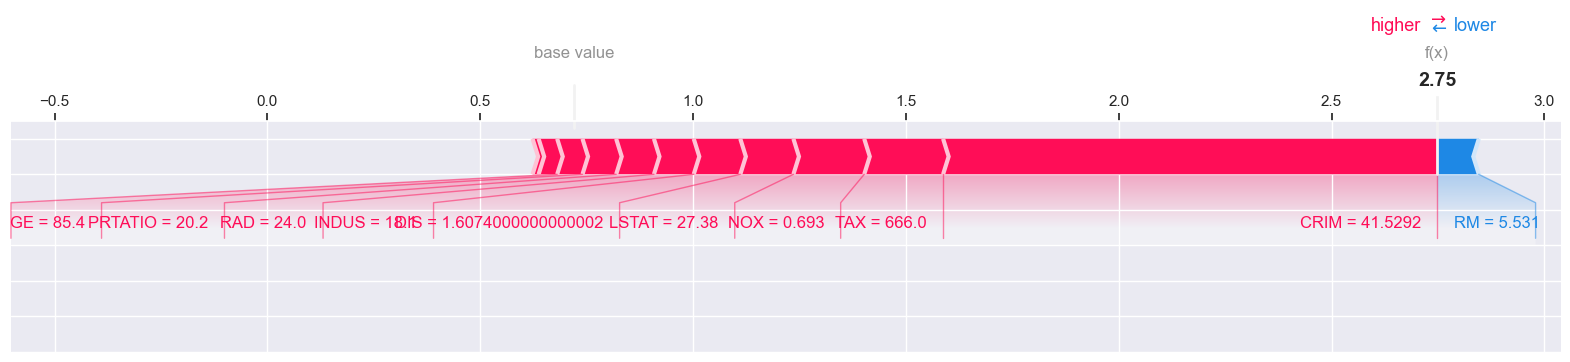

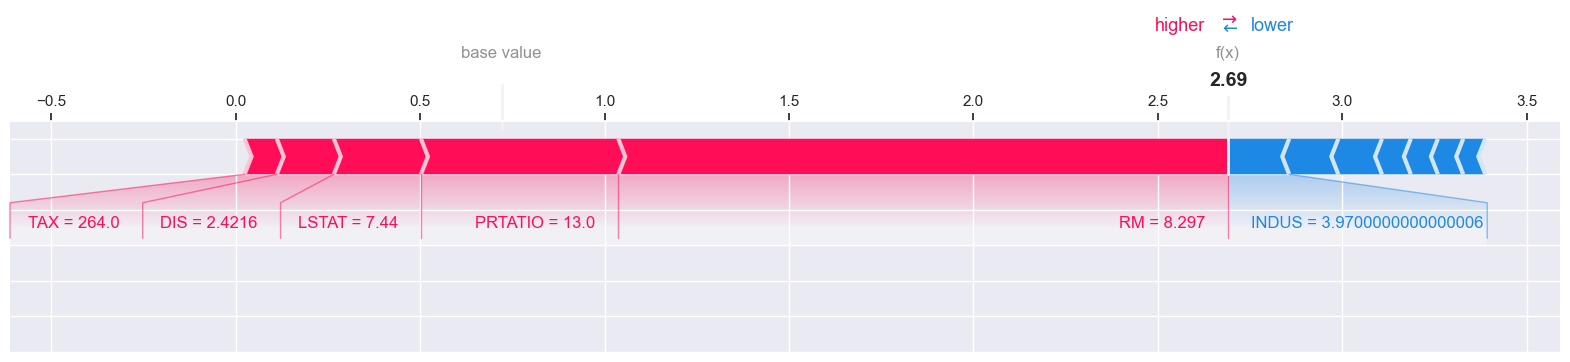

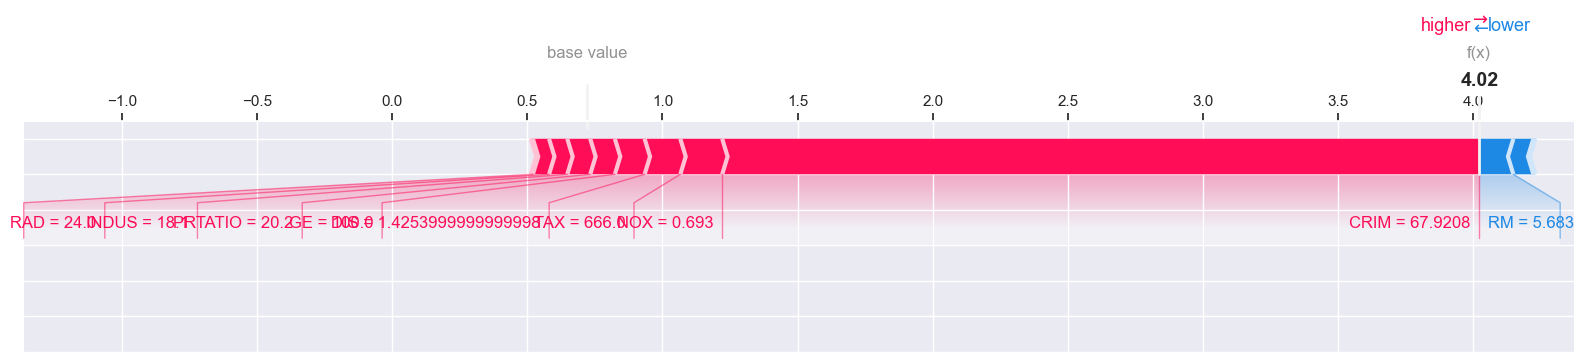

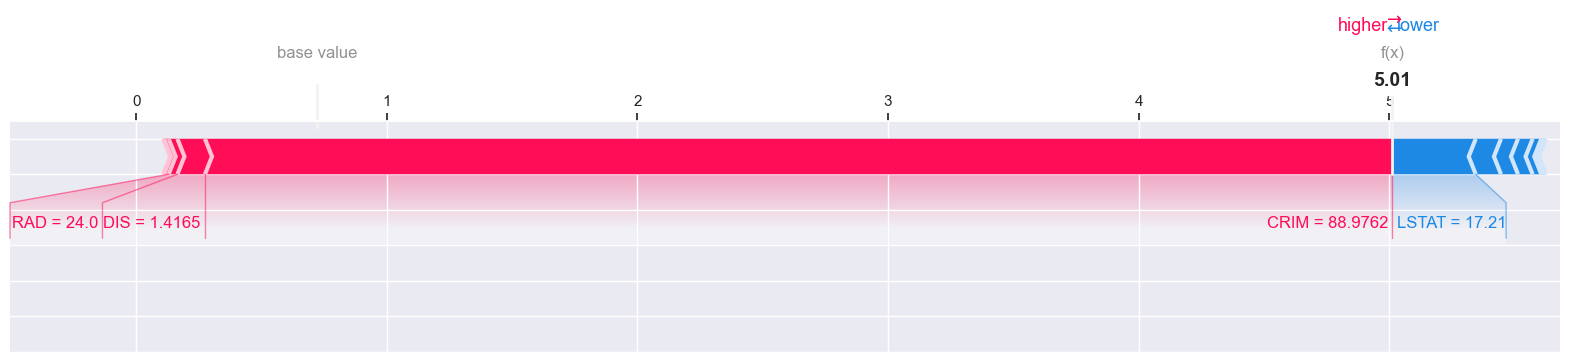

In [29]:
for i in range(5):

    selected_index= y_test_top_5_max_index[i]
    shap.force_plot(expected_value, shap_values[0][selected_index], pd.Series(x_test_inv[selected_index], index=x_column_names), show= False,  matplotlib= True)  
    # type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape:
    # <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)

    image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_max_index{selected_index}_force_plot.png'
    plt.savefig(image_name, bbox_inches='tight', dpi=300) 
    plt.show()
    plt.close()

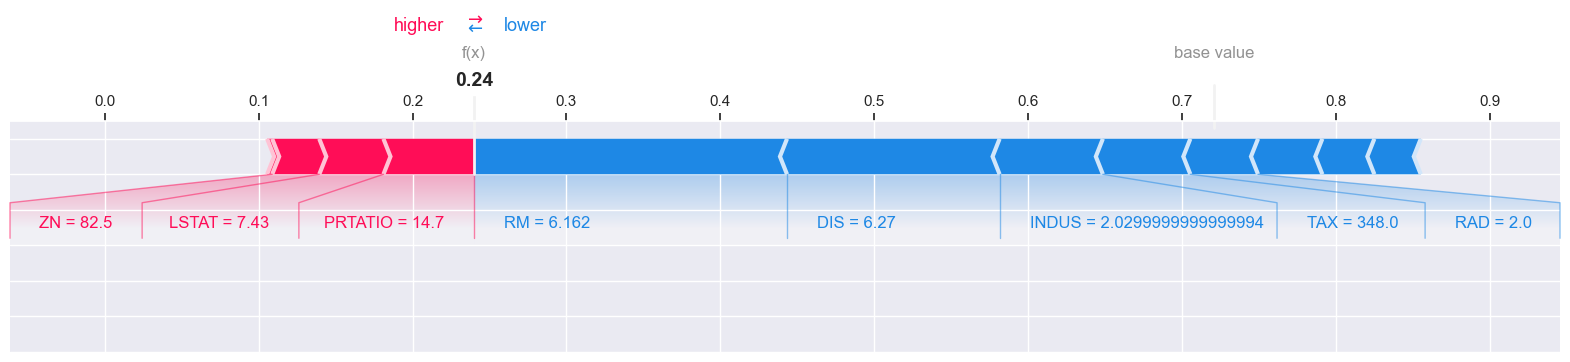

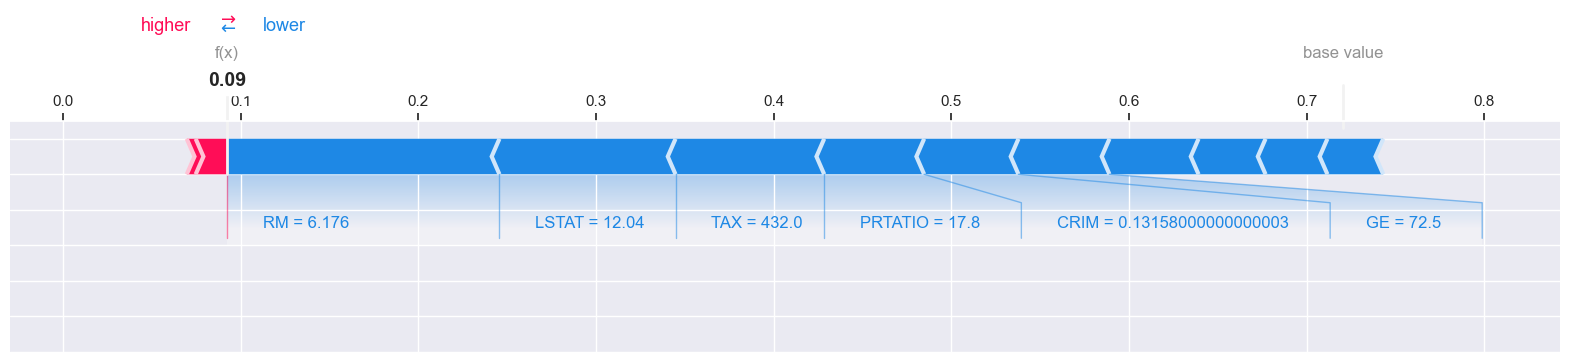

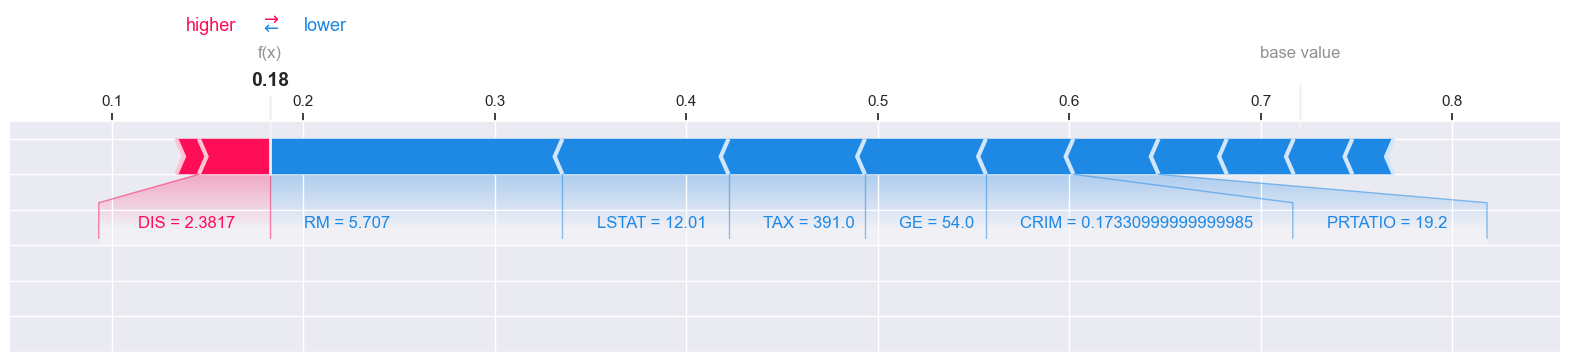

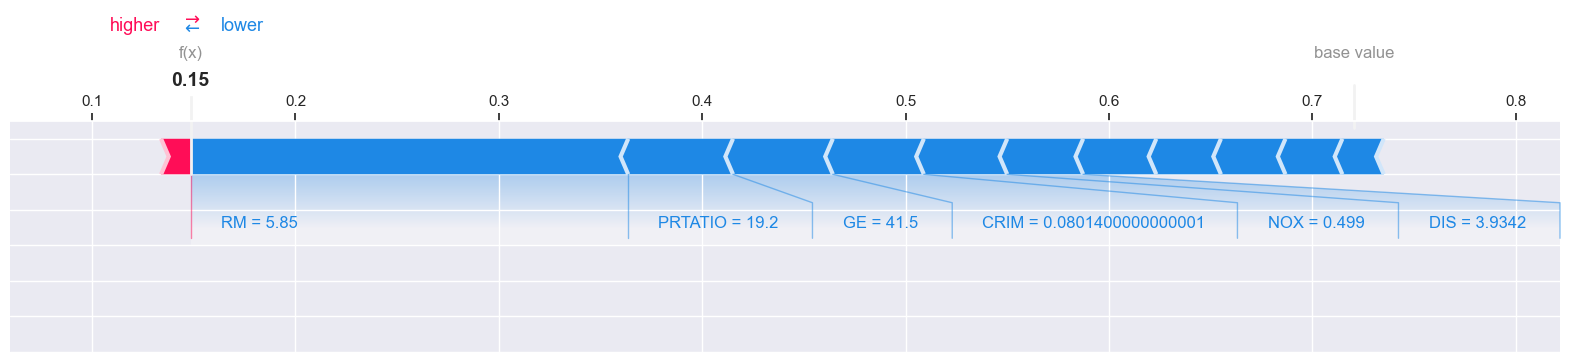

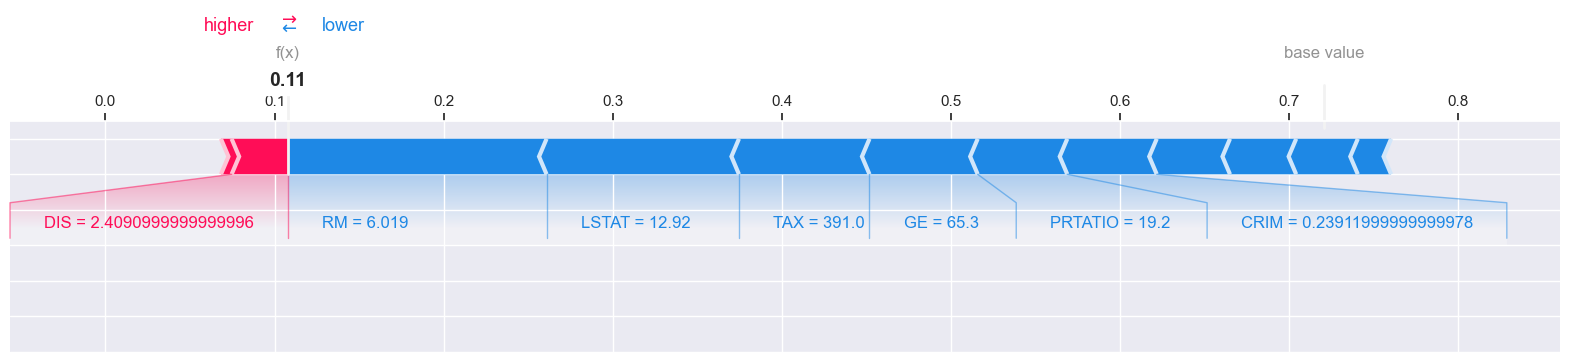

In [31]:
for i in range(5):

    selected_index= y_test_top_5_min_index[i]
    shap.force_plot(expected_value, shap_values[0][selected_index], pd.Series(x_test_inv[selected_index], index=x_column_names), show= False,  matplotlib= True)  
    # type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape:
    # <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)

    image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_min_index{selected_index}_force_plot.png'
    plt.savefig(image_name, bbox_inches='tight', dpi=300) 
    plt.show()
    plt.close()

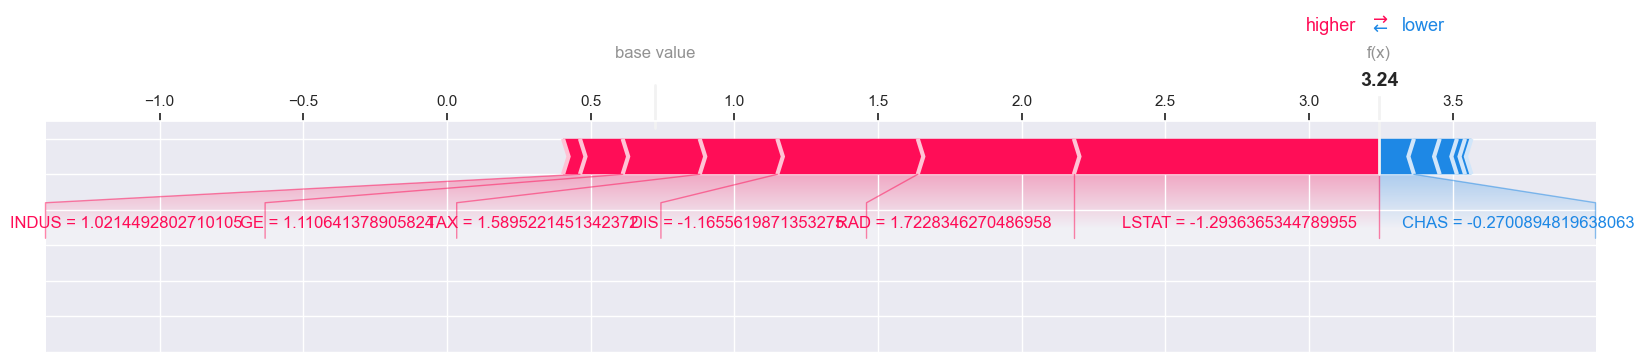

In [14]:

# selected_index = y_test_top_5_max_index[0]
selected_index= y_test_top_5_max_index[0]
shap.force_plot(expected_value, shap_values[0][selected_index], x_test_std.iloc[0, :], show= False,  matplotlib= True)  
# type(shap_values), len(shap_values), type(shap_values[0]), shap_values[0].shape, x_test_std.shape:
# <class 'list'>, 1, <class 'numpy.ndarray'> (102, 12) (102, 12)

image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_max_index{selected_index}_force_plot.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300) 
plt.show()
plt.close()

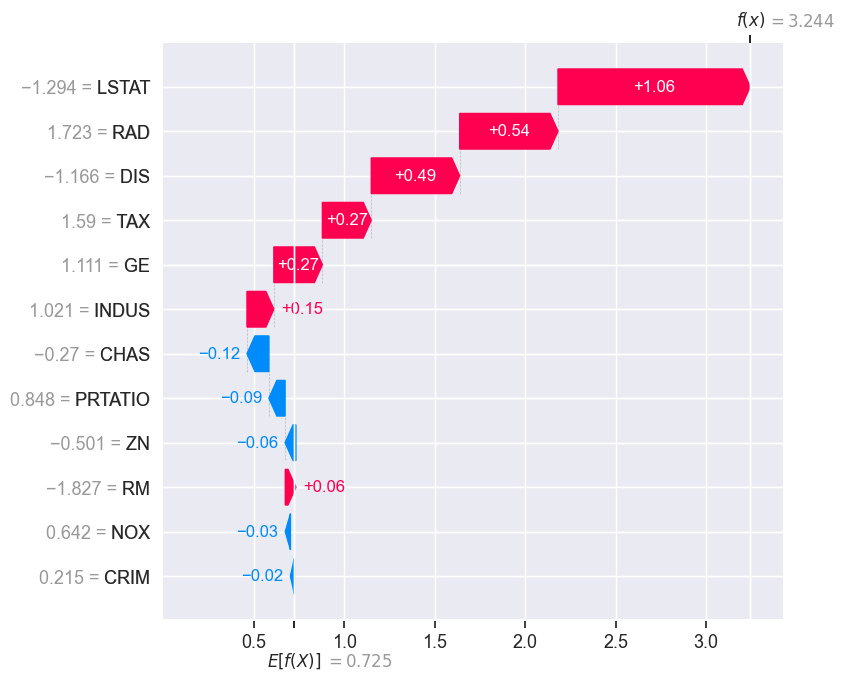

In [15]:
# Convert shap_values to shap.Explanation object
shap_explanation = shap.Explanation(values=shap_values[0][selected_index], 
									base_values=expected_value, 
									data=x_test_std.iloc[selected_index])

# Plot the waterfall plot with all features
shap.plots.waterfall(shap_explanation, max_display=len(x_column_names),show= False)

# Display the plot
image_name = f'../result/houseprice_SHAP_xai_variance_local_top_5_max_index{selected_index}_waterfall.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [ ]:
# Assuming shap_values and x_test_std are already defined
# Create a new dataset containing only the selected sample
shap_values_single_sample = np.expand_dims(shap_values[0][y_test_top_5_max_index[0]], axis=0)   #index from 0 to 4
x_test_single_sample = x_test_std.iloc[[selected_index]]

# Generate the summary plot for the single sample
shap.summary_plot(shap_values_single_sample, x_test_single_sample, show=False)
image_name = './houseprice_SHAP_xai_variance_max5_local0.png'
plt.savefig(image_name, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [32]:
pickle_file= open('./y_test_mean_y_test_STD.pickle','rb')
data_mean_std= pd.read_pickle(pickle_file) # is a list
pickle_file.close()

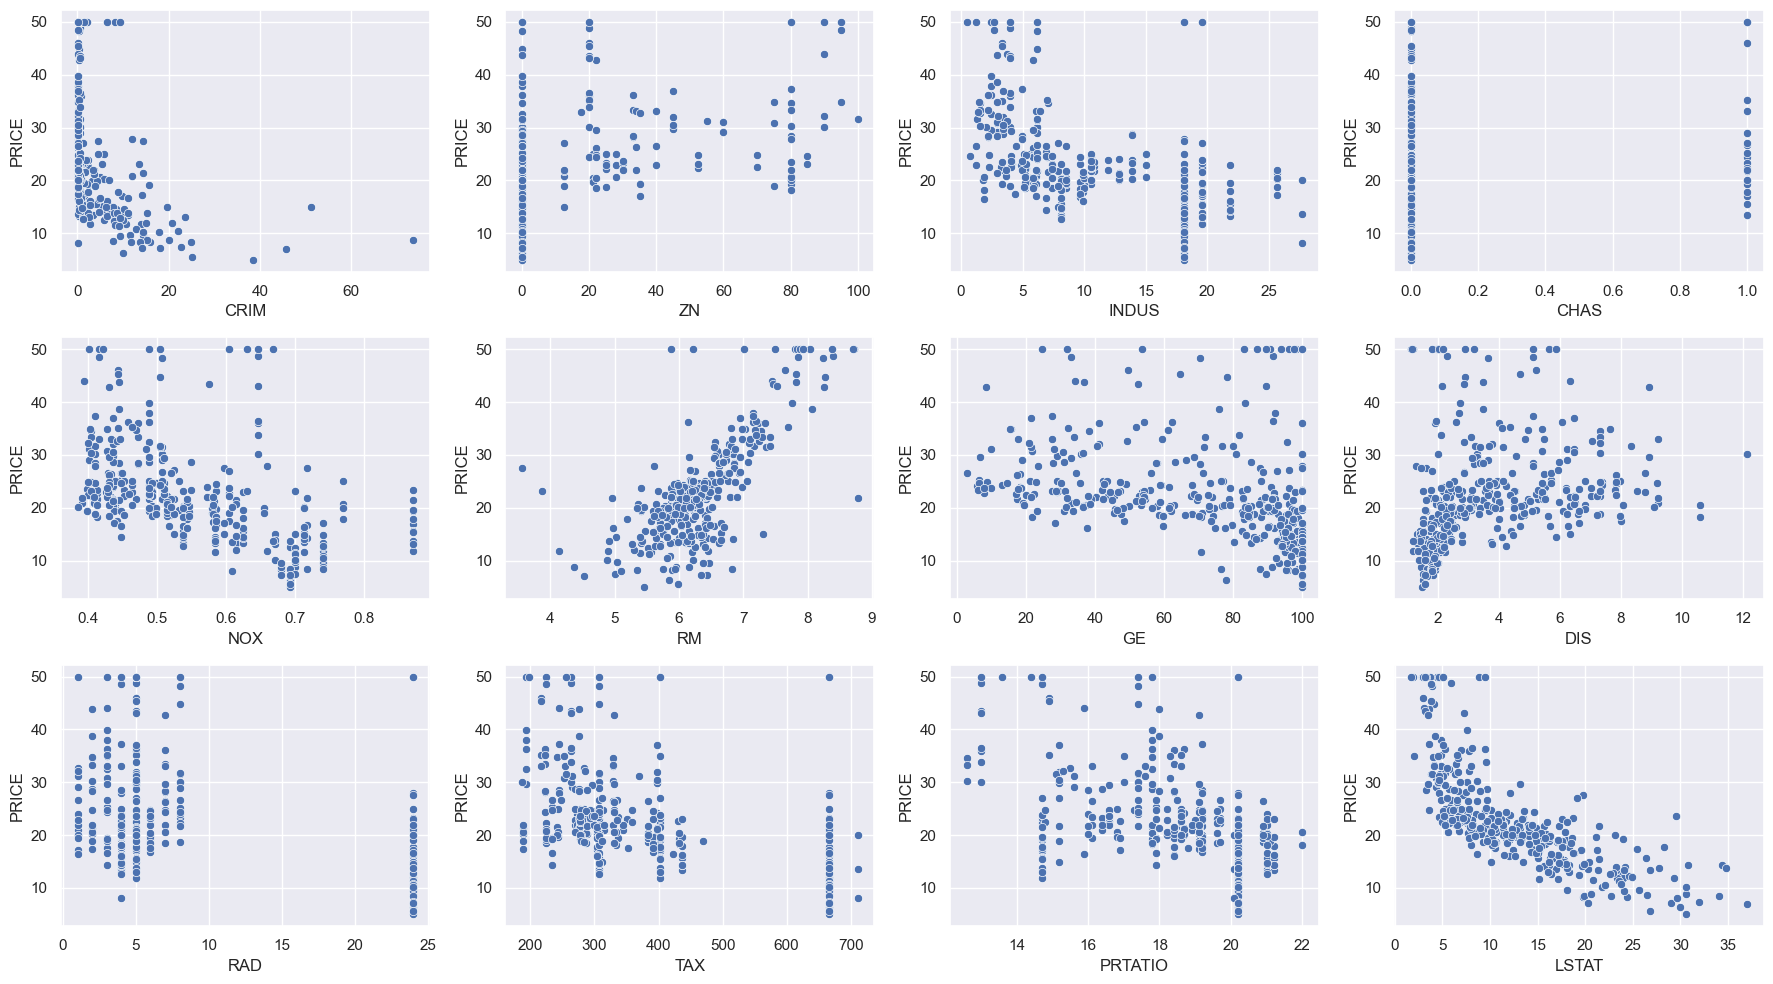

In [33]:
# 计算训练集均值和标准差
x_train_mean = x_train.mean()
x_train_STD = x_train.std()
y_train_mean = y_train.mean()
y_train_STD = y_train.std()

# 反标准化操作
x_train_inv = scaler_x.inverse_transform(x_train_std)
y_train_inv = scaler_y.inverse_transform(y_train_std)

# 创建关系图
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(x_column_names):
    # 反标准化后对应的列
    x_col_data = x_train_inv[:, i]
    y_col_data = y_train_inv[:, 0]  # 假设 y_train 只有一列

    # 绘制散点图
    sns.scatterplot(x=x_col_data, y=y_col_data, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('PRICE')

plt.tight_layout()
plt.show()


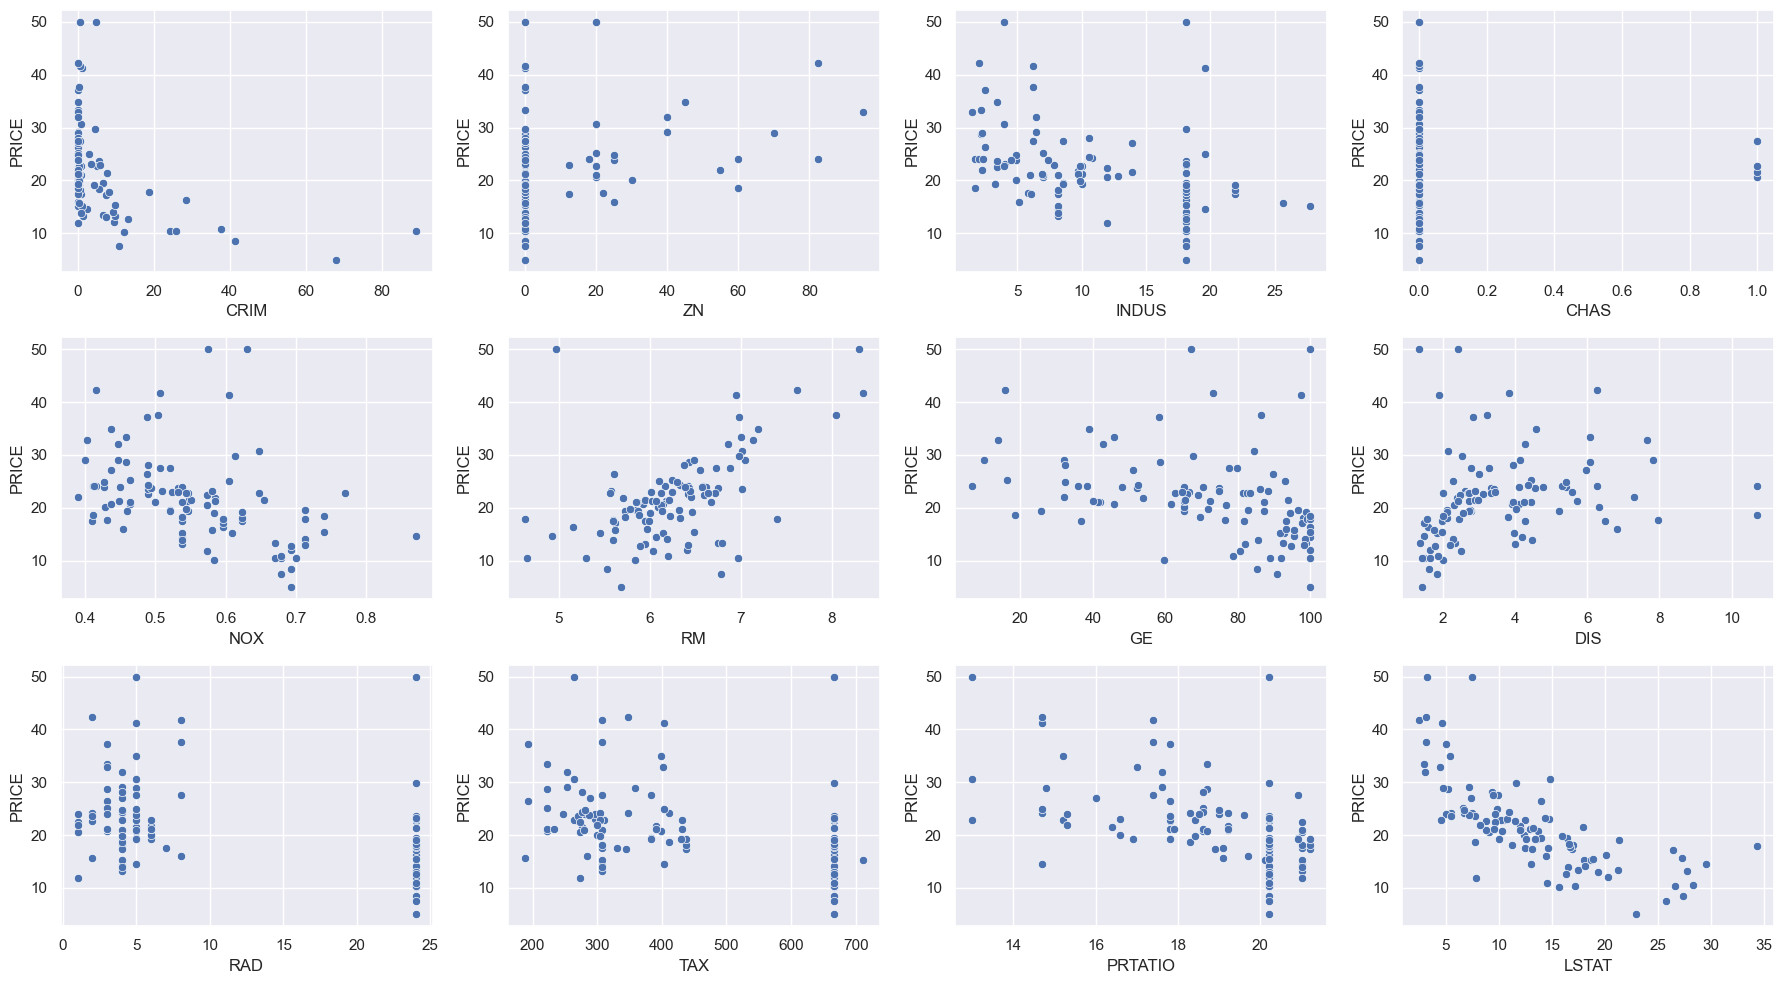

In [34]:
# 反标准化操作
x_test_inv = scaler_x.inverse_transform(x_test_std)
y_test_inv = scaler_y.inverse_transform(y_test_std)

# 创建关系图
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(x_column_names):
    # 反标准化后对应的列
    x_col_data = x_test_inv[:, i]
    y_col_data = y_test_inv[:, 0]  # 假设 y_train 只有一列

    # 绘制散点图
    sns.scatterplot(x=x_col_data, y=y_col_data, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('PRICE')

plt.tight_layout()
plt.show()

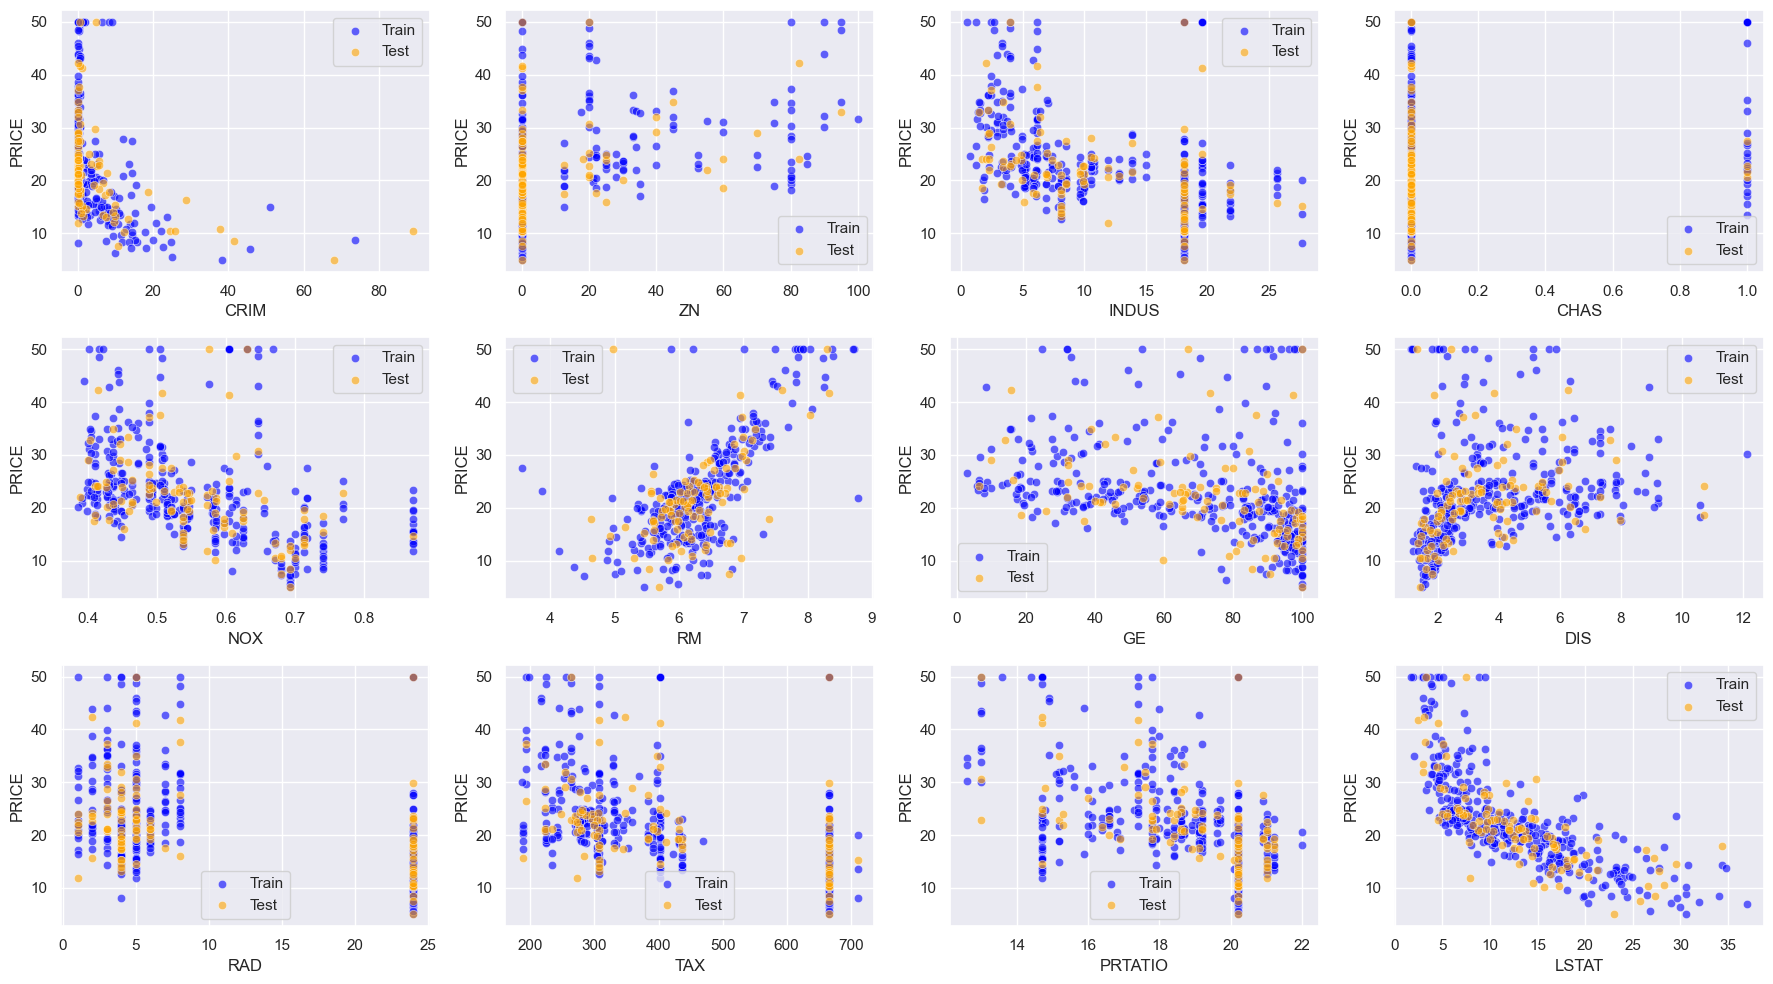

In [35]:
# Create combined scatter plots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(x_column_names):
    # Inverse-transformed data for the current column
    x_train_col = x_train_inv[:, i]
    y_train_col = y_train_inv[:, 0]  # Assuming y_train has one column
    x_test_col = x_test_inv[:, i]
    y_test_col = y_test_inv[:, 0]  # Assuming y_test has one column

    # Create scatter plots
    sns.scatterplot(x=x_train_col, y=y_train_col, ax=axes[i], color='blue', label='Train', alpha=0.6)
    sns.scatterplot(x=x_test_col, y=y_test_col, ax=axes[i], color='orange', label='Test', alpha=0.6)

    # Set titles and labels
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('PRICE')
    axes[i].legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


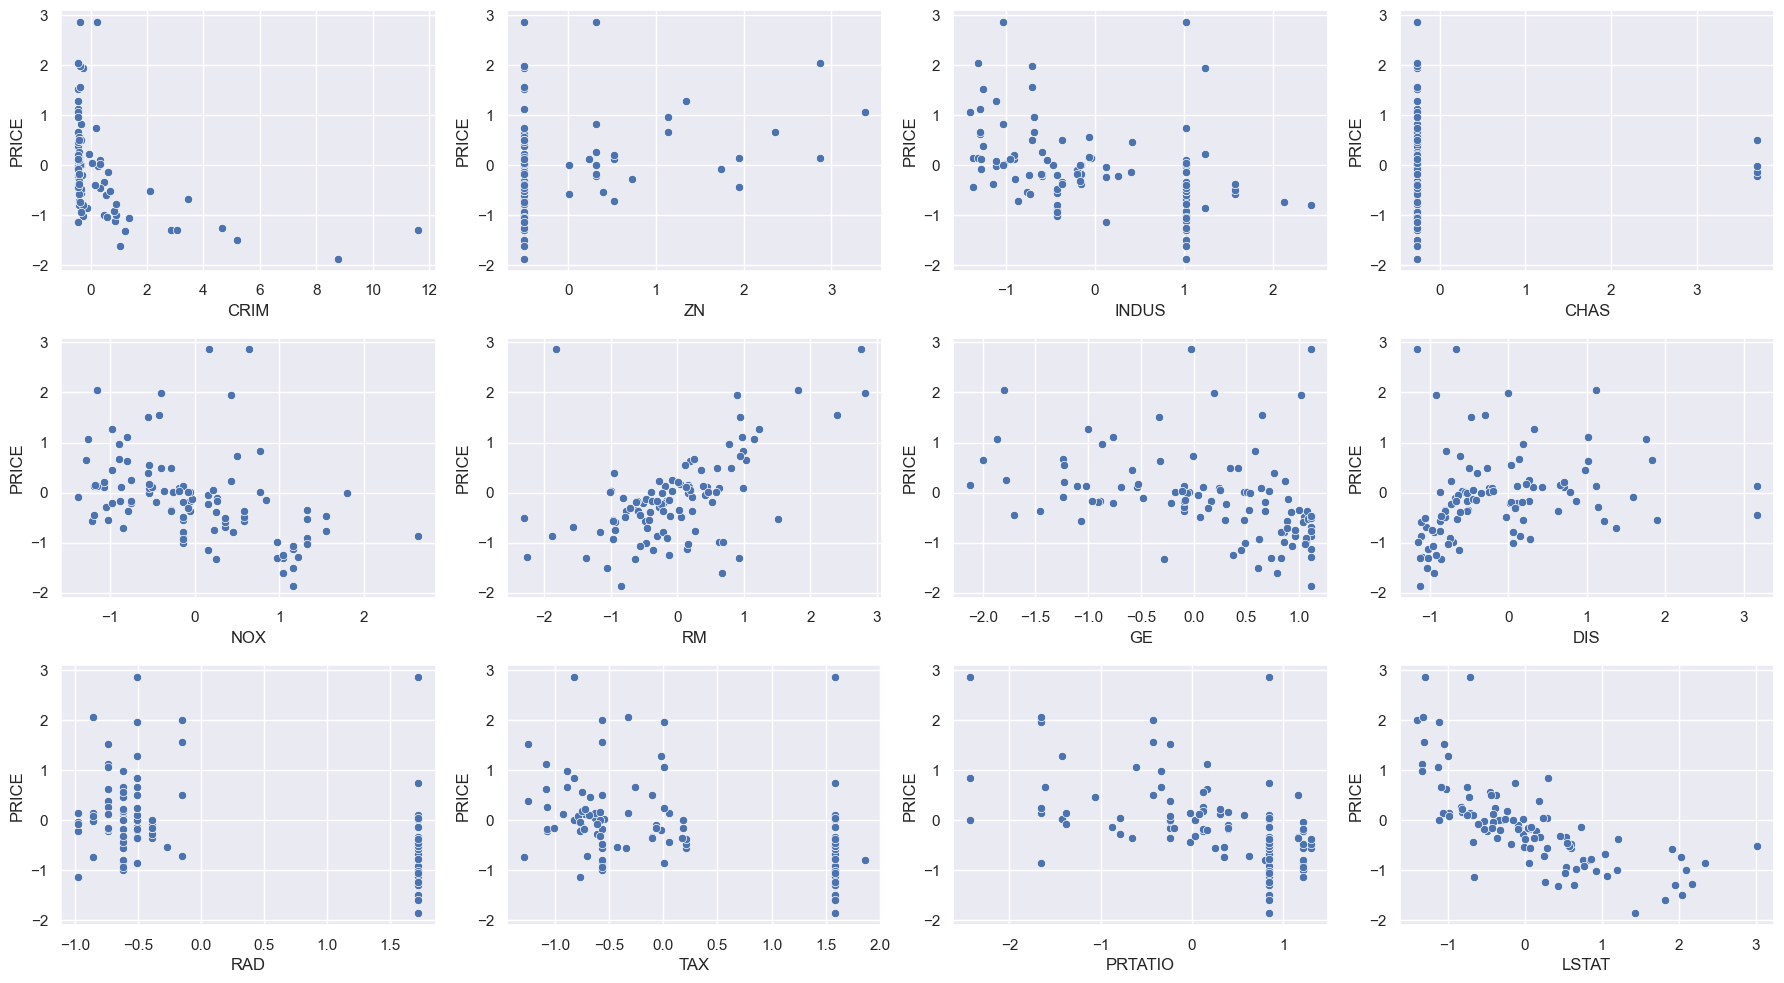

In [36]:
### No reversed ###

x_test_mean= x_test.mean()
x_test_STD= x_test.std()

y_test_mean= y_test.mean()
y_test_STD= y_test.std()
with open("y_test_mean_y_test_STD.pickle", "wb") as f:
    pickle.dump([y_test_mean, y_test_STD], f)
    # Plot the relationship between each feature in x_test_std and y_test_std
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 10))
    axes = axes.flatten()

    for i, col in enumerate(x_column_names):
        sns.scatterplot(x= x_test_std[col], y= y_test_std['PRICE'], ax=axes[i])
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('PRICE')

    plt.tight_layout()
    plt.show()
# b* np.array(data_mean_std[1])+ np.array(data_mean_std[0])